# Training delle SVM
In questo notebook addestreremo una SVM diversa per ogni Action Unit (AU) che vogliamo classificare.

### Parte I
0. Spiegazione relativa alle Action Unit (AU)
1. Prelievo di un'immagine del dataset con l'etichetta relativa
2. Suddivisione di un campione di immagini sulla base della presenza o meno di una certa AU
3. Fitting di un modello PCA di prova
4. Addestramento di una SVM di prova con validazione dei parametri C e Gamma

### Parte II
Per ogni AU che vogliamo saper classificare, effettueremo queste operazioni:
1. Selezioniamo un frame da uno dei dataset
2. Preleviamo dal dataset le AU presenti in tale frame
3. Se tra queste AU c'è quella che stiamo considerando, allora estraiamo le feature HOG del frame e le aggiungiamo alla lista degli esempi positivi che vogliamo dare al nostro modello. A queste feature verrà associata l'etichetta TRUE. Se tra queste AU non c'è quella che stiamo considerando, allora estraiamo le feature HOG del frame e le aggiungiamo alla lista degli esempi negativi, associando a tali feature l'etichetta FALSE. Facciamo in modo che il numero di esempi negativi sia uguale al numero di esempi positivi.
4. Suddividiamo i dati a disposizione in Training e Test Set
5. Effettuiamo il fitting di un modello PCA con i dati del Training Set. Poi trasformiamo i dati di Training e Test set utilizzando tale modello. La PCA verrà applicata anche ai nuovi dati prima di passarli al classificatore SVM
6. Addestriamo la SVM relativa alla AU che stiamo considerando
7. Salviamo i modelli PCA e SVM relativi alla AU considerata

# Parte I

Action Unit facciali:

<img src="images/AU.png" width="400">

Emozioni espresse come combinazione di AU:

<img src="images/emotions.png">

<br>

Funzioni di supporto per lo scorrimento del Dataset.

In [58]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


def show_gray_image_from_path(path):
    img = mpimg.imread(path)    
    imgplot = plt.imshow(img, cmap=plt.cm.gray)
    plt.show()
    
def change_extension_to_txt(text):
    return text[:-4] + "_facs.txt"
    
def get_aus(label_path, subpath):
    img_aus = list()  # lista delle AU della singola immagine
    fname = "{}/{}".format(label_path, change_extension_to_txt(subpath))
    if os.path.isfile(fname):  # se il file esiste
        f = open(fname,"r") 
        for line in f: 
            img_aus.append(int(float(line.split()[0])))
    return img_aus

<br>
Scorrimento del dataset CK+ e prelievo di un'immagine con relative AU (in questo caso nessuna).

dataset/CK+/cohn-kanade-images/S005/001/S005_001_00000001.png
AU: []


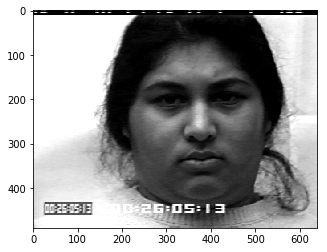

In [59]:
import os
from face_helpers import get_face_locations, get_landmarks, align_and_crop, get_hog_features, show_gray_image, show_image_from_path
import numpy as np

frame_path = "dataset/CK+/cohn-kanade-images"
label_path = "dataset/CK+/FACS"
counter = 0

for dir in os.listdir(frame_path):
    for subdir in os.listdir("{}/{}".format(frame_path, dir)):
        if not subdir.startswith('.'):
            for frame in os.listdir("{}/{}/{}".format(frame_path, dir, subdir)):
                if frame.endswith(".png") and counter < 1:
                    counter += 1
                    print("{}/{}/{}/{}".format(frame_path, dir, subdir, frame))
                    print("AU: {}".format(get_aus(label_path, "{}/{}/{}".format(dir, subdir, frame))))
                    show_gray_image_from_path("{}/{}/{}/{}".format(frame_path, dir, subdir, frame))

<br>
Esempio di immagine con la presenza di AU attive.

dataset/CK+/cohn-kanade-images/S005/001/S005_001_00000011.png
AU: [9, 17]


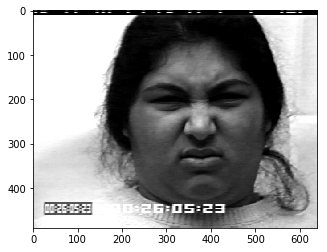

In [60]:
print("dataset/CK+/cohn-kanade-images/S005/001/S005_001_00000011.png")
print("AU: {}".format(get_aus(label_path, "S005/001/S005_001_00000011.txt"))) 
show_gray_image_from_path("dataset/CK+/cohn-kanade-images/S005/001/S005_001_00000011.png")

<br>
Suddivisione di un campione di immagini sulla base della presenza o meno di una certa AU:
estraiamo tutte le immagini del dataset che contengono la AU27.
Per avere un campione bilanciato, estraiamo uno stesso numero di immagini che NON contengono la AU27.
Notiamo che nel dataset abbiamo 81 immagini che presentano la AU27. <br>

Alla fine avremo:
* una matrice di feature 162 x 6084, in cui in ogni riga ci sono le feature relative ad un frame
* una lista di etichette associate a queste 162 immagini


In [61]:
def apply_pipeline(path, return_hog_image=False):
    img = get_face_locations(path, verbose=False)
    landmarks, _ = get_landmarks(img)
    img = align_and_crop(img, landmarks)
    return get_hog_features(img, flat_vector=True, return_image=return_hog_image)

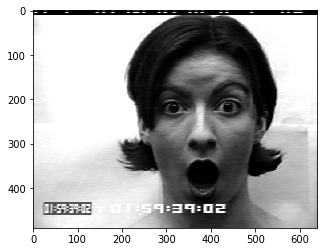

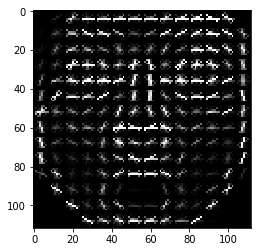

dataset/CK+/cohn-kanade-images/S010/002/S010_002_00000014.png     1
AU: [1, 2, 5, 25, 27]
-------------------------------------------------------------------
dataset/CK+/cohn-kanade-images/S011/001/S011_001_00000016.png     2
AU: [1, 2, 25, 27]
-------------------------------------------------------------------
dataset/CK+/cohn-kanade-images/S014/001/S014_001_00000029.png     3
AU: [1, 2, 5, 12, 25, 27]
-------------------------------------------------------------------
...
Shape della matrice di feature:  (162, 6084)
Numero di etichette:             162


In [62]:
au = 27
aus_list = list()
feature_list = list()
labels = list()
count_positive = 0
count_negative = 0

for dir in os.listdir(frame_path):
    for subdir in os.listdir("{}/{}".format(frame_path, dir)):
        if not subdir.startswith('.'):
            for frame in os.listdir("{}/{}/{}".format(frame_path, dir, subdir)):
                if frame.endswith(".png"):
                    aus_list = get_aus(label_path, "{}/{}/{}".format(dir, subdir, frame))                    
                    if au in aus_list:  
                        if count_positive == 0:
                            fd, hog_image = apply_pipeline("{}/{}/{}/{}".format(frame_path, dir, subdir, frame), return_hog_image=True)
                            show_gray_image_from_path("{}/{}/{}/{}".format(frame_path, dir, subdir, frame))
                            show_gray_image(hog_image)
                        else:
                            fd = apply_pipeline("{}/{}/{}/{}".format(frame_path, dir, subdir, frame))
                
                        if count_positive < 3:
                            print("{}/{}/{}/{}     {}".format(frame_path, dir, subdir, frame, count_positive+1))
                            print("AU: {}".format(aus_list))
                            print("-------------------------------------------------------------------")
                        if count_positive == 3:
                            print("...")
                            
                        count_positive += 1
                        feature_list.append(fd)
                        labels.append(1)
                    
                    else:
                        if count_positive > count_negative:
                            count_negative += 1
                            feature_list.append(apply_pipeline("{}/{}/{}/{}".format(frame_path, dir, subdir, frame)))
                            labels.append(0) 
                    
feature_list = np.asarray(feature_list)
print("Shape della matrice di feature: ", feature_list.shape)
print("Numero di etichette:            ", len(labels))

<br>
Suddivisione del campione di dati in Training e Test set.

In [63]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(feature_list, labels, test_size=0.2, random_state=0)

print("X_train: {} \nX_test: {}".format(X_train.shape, X_test.shape))

X_train: (129, 6084) 
X_test: (33, 6084)


<br>
Passiamo la nostra feature_list ad un modello PCA per ridurre la dimensionalità delle colonne. <br>
In questo caso passiamo da 6084 colonne a 107 colonne.

In [64]:
from sklearn.decomposition import PCA

# Fit del modello PCA
pca = PCA(n_components=.95)
pca.fit(X_train)

# applicazione della PCA alla feature_list
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("X_train: {} \nX_test: {}".format(X_train_pca.shape, X_test_pca.shape))

X_train: (129, 107) 
X_test: (33, 107)


<br>

Validiamo i parametri C e Gamma della SVM ([Tutorial](http://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/auto_examples/svm/plot_svm_parameters_selection.html))

In [65]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Scaliamo i dati
scaler = StandardScaler()
scaler.fit(X_train_pca)
X_train_pca = scaler.transform(X_train_pca)
X_test_pca = scaler.transform(X_test_pca)

# Grid Search
# Parameter Grid
param_grid = {'C': [100, 10, 1, 0.1, 0.001], 'gamma': [0.00001, 0.001, 0.01]}

 
# Make grid search classifier
clf_grid = GridSearchCV(SVC(), param_grid, verbose=1, cv=5, n_jobs=-1)
 
# Train the classifier
clf_grid.fit(X_train_pca, y_train)
 
print("Best Parameters:     ", clf_grid.best_params_)
#print("Best Estimators:     ", clf_grid.best_estimator_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Parameters:      {'C': 100, 'gamma': 0.01}


[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    2.1s finished


c:\users\luca\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


{'C': 100, 'gamma': 0.01} -> Average Score: 0.74


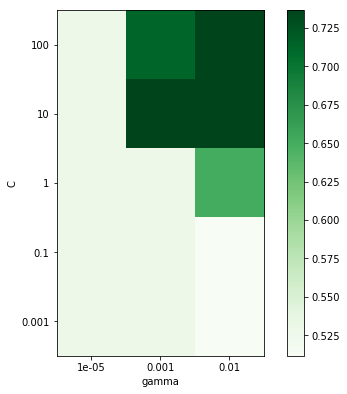

In [66]:
# plot the scores of the grid
# grid_scores_ contains parameter settings and scores
score_dict = clf_grid.grid_scores_

# We extract just the scores
scores = [x[1] for x in score_dict]
scores = np.array(scores).reshape(len(param_grid['C']), len(param_grid['gamma']))

print("{0} -> Average Score: {1:.2f}".format(clf_grid.best_params_, scores.max()))

# Make a nice figure
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.Greens)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['gamma'])), param_grid['gamma'])
plt.yticks(np.arange(len(param_grid['C'])), param_grid['C'])
plt.show()

<br>
Addestriamo una SVM con questi dati di prova

In [67]:
#from sklearn.svm import SVC

clf = clf_grid.best_estimator_
clf.fit(X_train_pca, y_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

<br>
Implementiamo due funzioni per il calcolo dell'accuracy su Training e Test set.

In [68]:
def get_accuracy(predicted_labels, true_labels):
    counter_ok = 0.0
    for i in range(len(predicted_labels)):
        if predicted_labels[i] == true_labels[i]:
            counter_ok += 1
    return counter_ok

<br>
Vediamo l'accuratezza.

In [69]:
predicted_labels = clf.predict(X_test_pca)               
counter_ok = get_accuracy(predicted_labels, y_test)
print("Test Score  -> {0}/{1} = {2:.2f} %"\
      .format(int(counter_ok), len(predicted_labels), (counter_ok / len(predicted_labels)*100)))

predicted_labels = clf.predict(X_train_pca)
counter_ok = get_accuracy(predicted_labels, y_train)
print("Train Score -> {0}/{1} = {2:.2f} %"\
      .format(int(counter_ok), len(predicted_labels), (counter_ok / len(predicted_labels)*100)))

Test Score  -> 32/33 = 96.97 %
Train Score -> 129/129 = 100.00 %


<br>
Proviamo il modello su un dato esterno che presenta la AU27.

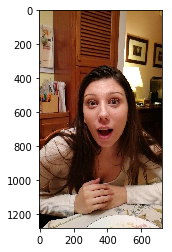

feature vector shape:  (1, 107)
A27:  True


In [70]:
labels_dict = {0: "False", 1: "True"}

show_image_from_path("images/AU27_prova1.jpg")
fd = apply_pipeline("images/AU27_prova1.jpg")
fd = pca.transform(fd.reshape(1,-1))

print("feature vector shape: ", fd.shape)
print("A27: ", labels_dict[clf.predict(fd)[0]])

<br>
Proviamo il modello su un dato esterno che NON presenta la AU27.

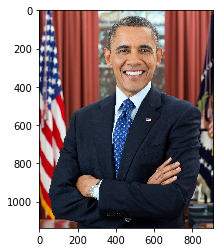

feature vector shape:  (1, 107)
A27:  False


In [71]:
show_image_from_path("images/obama.jpg")
fd = apply_pipeline("images/obama.jpg")
fd = pca.transform(fd.reshape(1,-1))

print("feature vector shape: ", fd.shape)
print("A27: ", labels_dict[clf.predict(fd)[0]])

<br>
Implementiamo due funzioni per memorizzare e caricare un modello (sia per PCA che per SVM)

In [72]:
from sklearn.externals import joblib
models_path = "models"

def save_model(model, name):
    joblib.dump(model, "{}/{}".format(models_path, name))
    
def load_model(name):
    return joblib.load("{}/{}".format(models_path, name))

In [73]:
save_model(clf, "svm_prova")
loaded_clf = load_model("svm_prova")
print("A27: ", labels_dict[clf.predict(fd)[0]])
print("A27: ", labels_dict[loaded_clf.predict(fd)[0]])

A27:  False
A27:  False


***

# Parte II
Applichiamo lo stesso procedimento visto nella prima parte per ogni AU che ci interessa e considerando i dati presenti nei diversi Dataset. Per motivi di tempo, le SVM sono state addestrate in momenti diversi e non tutte insieme.

In [34]:
def add_data(au, feature_list, labels, frame_path, label_path):
    aus_list = list()
    global count_positive
    global count_negative

    for dir in os.listdir(frame_path):
        for subdir in os.listdir("{}/{}".format(frame_path, dir)):
            if not subdir.startswith('.'):
                for frame in os.listdir("{}/{}/{}".format(frame_path, dir, subdir)):
                    if frame.endswith(".png"):
                        aus_list = get_aus(label_path, "{}/{}/{}".format(dir, subdir, frame))                    
                        if au in aus_list:  
                            try:
                                fd = apply_pipeline("{}/{}/{}/{}".format(frame_path, dir, subdir, frame))
                                count_positive += 1
                                feature_list.append(fd)
                                labels.append(1)
                            except:
                                pass
                        
                        else:
                            if count_positive > count_negative:
                                try:
                                    count_negative += 1
                                    feature_list.append(apply_pipeline("{}/{}/{}/{}".format(frame_path, dir, subdir, frame)))
                                    labels.append(0)
                                except:
                                    pass

In [39]:
#aus = [1, 2, 4, 5, 6, 7, 9, 12, 14, 15, 16, 20, 23, 26]
aus = [5, 7, 9, 14, 16, 20, 23, 26]
scaler = StandardScaler()
param_grid = {'C': [100, 10, 1, 0.1], 'gamma': [0.0001, 0.001, 0.01]}


for au in aus:
    print("AU: ", au)
    count_positive = 0
    count_negative = 0
    feature_list = list()
    labels = list()
    print("     - Aggiungo i dati da {}...".format("CK+"))
    add_data(au, feature_list, labels, frame_path = "dataset/CK+/cohn-kanade-images", label_path = "dataset/CK+/FACS") 
    print("     - Aggiungo i dati da {}...".format("UNBC"))
    add_data(au, feature_list, labels, frame_path = "dataset/UNBC-pain/Images", label_path = "dataset/UNBC-pain/Frame_Labels/FACS")
    feature_list = np.asarray(feature_list)
    print("          Shape della matrice di feature: ", feature_list.shape)
    print("          Numero di etichette:            ", len(labels))
    
    
    print("     - Suddivido i dati in Training e Test set...")
    X_train, X_test, y_train, y_test = model_selection.train_test_split(feature_list, labels, test_size=0.2, random_state=0)
    print("          X_train: {} \n          X_test:  {}".format(X_train.shape, X_test.shape))
    
    
    print("     - Riduco la dimensionalità dei dati...")
    pca = PCA(n_components=.95)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    print("          X_train: {} \n          X_test:  {}".format(X_train_pca.shape, X_test_pca.shape))
    
    
    print("     - Valido i parametri C e Gamma...")
    scaler.fit(X_train_pca)
    X_train_pca = scaler.transform(X_train_pca)
    X_test_pca = scaler.transform(X_test_pca)
    clf_grid = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1)
    clf_grid.fit(X_train_pca, y_train)
    print("          Best Parameters: ", clf_grid.best_params_)
    
    
    print("     - Addestro la SVM...")
    clf = clf_grid.best_estimator_
    clf.fit(X_train_pca, y_train)
    predicted_labels = clf.predict(X_test_pca)               
    counter_ok = get_accuracy(predicted_labels, y_test)
    print("          Test Score  -> {0}/{1} = {2:.2f} %"\
          .format(int(counter_ok), len(predicted_labels), (counter_ok / len(predicted_labels)*100)))

    predicted_labels = clf.predict(X_train_pca)
    counter_ok = get_accuracy(predicted_labels, y_train)
    print("          Train Score -> {0}/{1} = {2:.2f} %"\
          .format(int(counter_ok), len(predicted_labels), (counter_ok / len(predicted_labels)*100)))
    
    
    print("     - Salvo i modelli...")
    save_model(pca, "pca_au{}".format(au))
    save_model(clf, "svm_au{}".format(au))
    print("--------------------------------------------------------")

AU:  5
     - Aggiungo i dati da CK+...
     - Aggiungo i dati da UNBC...
          Shape della matrice di feature:  (204, 6084)
          Numero di etichette:             204
     - Suddivido i dati in Training e Test set...
          X_train: (163, 6084) 
          X_test:  (41, 6084)
     - Riduco la dimensionalità dei dati...
          X_train: (163, 133) 
          X_test:  (41, 133)
     - Valido i parametri C e Gamma...
          Best Parameters:  {'C': 100, 'gamma': 0.001}
     - Addestro la SVM...
          Test Score  -> 35/41 = 85.37 %
          Train Score -> 163/163 = 100.00 %
     - Salvo i modelli...
--------------------------------------------------------
AU:  7
     - Aggiungo i dati da CK+...
     - Aggiungo i dati da UNBC...
          Shape della matrice di feature:  (6529, 6084)
          Numero di etichette:             6529
     - Suddivido i dati in Training e Test set...
          X_train: (5223, 6084) 
          X_test:  (1306, 6084)
     - Riduco la dimensiona

<br>
Proviamo con l'AU2.

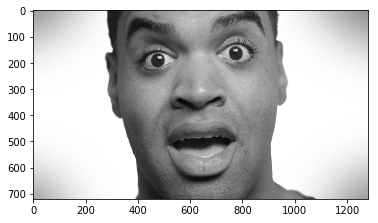

feature vector shape:  (1, 150)
A2:  True


In [40]:
show_image_from_path("images/prova_au2.jpg")
fd = apply_pipeline("images/prova_au2.jpg")

pca = load_model("pca_au2")
fd = pca.transform(fd.reshape(1,-1))
loaded_clf = load_model("svm_au2")

print("feature vector shape: ", fd.shape)
print("A2: ", labels_dict[loaded_clf.predict(fd)[0]])

<br>
Proviamo con l'AU6.

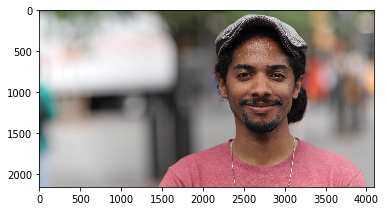

feature vector shape:  (1, 1173)
A6:  True


In [41]:
show_image_from_path("images/prova_happiness.png")
fd = apply_pipeline("images/prova_happiness.png")

pca = load_model("pca_au6")
fd = pca.transform(fd.reshape(1,-1))
loaded_clf = load_model("svm_au6")

print("feature vector shape: ", fd.shape)
print("A6: ", labels_dict[loaded_clf.predict(fd)[0]])

***

In [ ]:
'''
1) Guarda i parametri usati in OpenFace ad esempio per la validazione di C e Gamma
2) aggiungi anche il terzo dataset
'''